In [36]:
!pip install tensorflow tensorflow-probability gym matplotlib numpy

# trainer.py

In [37]:
import numpy as np
from typing import Optional, Dict

from tqdm import trange
import matplotlib.pyplot as plt

from src.SAC import *             
from src.MeshEnvironment import * 

__all__ = ['SACTrainer']

class SACTrainer:
    def __init__(self, env, agent, replay_buffer,
                 total_timesteps=100_000,
                 batch_size=256,
                 initial_random_steps=10_000,
                 eval_interval=5_000,
                 max_ep_len=100):
        self.env = env
        self.agent = agent
        self.replay_buffer = replay_buffer
        
        self.total_timesteps = total_timesteps
        self.batch_size = batch_size
        self.initial_random_steps = initial_random_steps
        self.eval_interval = eval_interval
        self.max_ep_len = max_ep_len

        self.results = {
            'timesteps': [],
            'episode_returns': [],
            'actor_losses': [],
            'critic_losses': [],
            'alpha_values': []
        }

    def train(self):
        state, _ = self.env.reset()
        episode_return, episode_length = 0, 0

        for t in range(1, self.total_timesteps + 1):
            if t < self.initial_random_steps:
                action = self.env.action_space.sample()
            else:
                action = self.agent.select_action(state)

            next_state, reward, done, truncated, _ = self.env.step(action)
            self.replay_buffer.add(state, action, reward, next_state, done)

            episode_return += reward
            episode_length += 1
            state = next_state

            if done or truncated or episode_length >= self.max_ep_len:
                print(f"Episode Return: {episode_return:.2f} | Elements: {len(self.env.elements)}")
                self.results['timesteps'].append(t)
                self.results['episode_returns'].append(episode_return)
                state, _ = self.env.reset()
                episode_return, episode_length = 0, 0

            if self.replay_buffer.size() >= self.batch_size and t >= self.initial_random_steps:
                batch = self.replay_buffer.sample(self.batch_size)
                train_info = self.agent.train_step(batch)

                if t % 1000 == 0:
                    self.results['actor_losses'].append(train_info['actor_loss'])
                    self.results['critic_losses'].append(
                        (train_info['critic_1_loss'] + train_info['critic_2_loss']) / 2
                    )
                    self.results['alpha_values'].append(train_info['alpha'])
                    print(f"Timestep: {t} | Actor Loss: {train_info['actor_loss']:.4f} | "
                          f"Critic Loss: {(train_info['critic_1_loss'] + train_info['critic_2_loss']) / 2:.4f} | "
                          f"Alpha: {train_info['alpha']:.4f}")

            if t % self.eval_interval == 0:
                eval_return = self.evaluate()
                print(f"Evaluation at timestep {t}: {eval_return:.2f}")

        return self.results

    def evaluate(self, num_episodes=5, render=False):
        returns = []
        for _ in range(num_episodes):
            state, _ = self.env.reset()
            done, ep_len, total = False, 0, 0
            while not done and ep_len < self.max_ep_len:
                action = self.agent.select_action(state, evaluate=True)
                state, reward, done, truncated, _ = self.env.step(action)
                total += reward
                ep_len += 1
                if render: self.env.render()
                if truncated: break
            returns.append(total)
        return np.mean(returns)


2025-04-13 23:10:14.025096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744585814.047386      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744585814.056594      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# MeshEnvironment.py

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import gym
from gym import spaces
from collections import deque
import random
import os
from typing import List, Tuple, Dict, Optional, Union, Any

__all__ = ['MeshEnvironment']

class MeshEnvironment(gym.Env):
    def __init__(self, initial_boundary=None, interior_points=None):
        # Initialize domain boundary
        if initial_boundary is None:
            self.initial_boundary = np.array([
                [-1, -1], [1, -1], [1, 1], [-1, 1]
            ])
        else:
            self.initial_boundary = initial_boundary
            
        # Interior points (optional)
        self.interior_points = interior_points if interior_points is not None else np.array([[0, 0]])
        
        # Initialize other properties
        self.boundary = self.initial_boundary.copy()
        self.elements = []
        self.element_qualities = []
        self.original_area = self._calculate_polygon_area(self.initial_boundary)
        
        # Parameters
        self.n_rv = 2
        self.g = 3
        self.beta = 6
        
        # Create initial state
        temp_state = self._get_state_initial()
        state_size = temp_state.shape[0]
        
        # Define action and observation spaces
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(3,), dtype=np.float32
        )
        
        self.observation_space = spaces.Box(
            low=-2, high=2, shape=(state_size,), dtype=np.float32
        )
        
        # Reset the environment
        self.reset()
    
    def reset(self, seed=None):
        super().reset(seed=seed)
        self.boundary = self.initial_boundary.copy()
        self.elements = []
        self.element_qualities = []
        state = self._get_state()
        return state, {}
    
    def step(self, action):
        # Convert normalized action to actual values
        action_type = int((action[0] + 1) * 1.5)  # Map [-1,1] to [0,3)
        action_type = min(2, max(0, action_type))  # Clip to [0,2]
        
        # Get reference vertex
        reference_vertex = self._select_reference_vertex()
        
        # Convert to cartesian coordinates relative to reference
        radius = self._calculate_fan_shape_radius(reference_vertex)
        angle = (action[1] + 1) * np.pi  # Maps [-1,1] to [0,2π]
        distance = (action[2] + 1) / 2 * radius  # Maps [-1,1] to [0,radius]
        
        # Calculate new vertex position
        new_vertex = reference_vertex + np.array([
            distance * np.cos(angle),
            distance * np.sin(angle)
        ])
        
        # Try to form a quad element
        new_element, valid = self._form_element(reference_vertex, action_type, new_vertex)
        
        if not valid:
            # Invalid element formation
            return self._get_state(), -0.1, False, False, {"valid": False}
        
        # Add element to mesh
        self.elements.append(new_element)
        quality = self._calculate_element_quality(new_element)
        self.element_qualities.append(quality)
        
        # Update boundary
        self._update_boundary(new_element)
        
        # Check if meshing complete
        remaining_area = self._calculate_polygon_area(self.boundary)
        area_ratio = remaining_area / self.original_area
        
        if len(self.boundary) <= 4 and self._is_quadrilateral(self.boundary):
            # Meshing complete
            return self._get_state(), 10.0, True, False, {"complete": True}
        
        # Calculate reward
        reward = self._calculate_reward(new_element, quality, area_ratio)
        return self._get_state(), reward, False, False, {"valid": True}
    
    def _get_state_initial(self):
        """Initial state vector of fixed size that doesn't reference observation_space"""
        state_components = []
        
        # Process surrounding vertices (2 on each side, 3 components each)
        for _ in range(4):
            state_components.extend([0, 0, 0])
        
        # Process fan-shaped area points (3 points, 3 components each)
        for _ in range(3):
            state_components.extend([0, 0, 1])
        
        # Add area ratio
        state_components.append(1.0)
        
        return np.array(state_components, dtype=np.float32)
    
    def _get_state(self):
        """Create state representation from current boundary"""
        if len(self.boundary) < 3:
            return np.zeros(22, dtype=np.float32)
        
        # Select reference vertex
        reference_vertex = self._select_reference_vertex()
        ref_idx = -1
        for i, v in enumerate(self.boundary):
            if np.array_equal(v, reference_vertex):
                ref_idx = i
                break
        
        if ref_idx == -1:
            return np.zeros(22, dtype=np.float32)
        
        # Get surrounding vertices
        surrounding_vertices = []
        for i in range(1, self.n_rv + 1):
            left_idx = (ref_idx - i) % len(self.boundary)
            right_idx = (ref_idx + i) % len(self.boundary)
            
            surrounding_vertices.append(self.boundary[left_idx])
            surrounding_vertices.append(self.boundary[right_idx])
        
        # Calculate fan-shaped area points
        radius = self._calculate_fan_shape_radius(reference_vertex)
        fan_points = self._get_fan_shape_points(reference_vertex, radius)
        
        # Calculate remaining area ratio
        remaining_area = self._calculate_polygon_area(self.boundary)
        area_ratio = remaining_area / self.original_area
        
        # Build state vector
        state_components = []
        
        # Process surrounding vertices
        for vertex in surrounding_vertices:
            rel_vector = vertex - reference_vertex
            distance = np.linalg.norm(rel_vector)
            angle = np.arctan2(rel_vector[1], rel_vector[0])
            
            # Normalize and add to state
            norm_distance = distance / radius
            norm_angle = angle / np.pi
            
            state_components.extend([norm_distance, norm_angle, 0])
        
        # Process fan-shaped area points
        for point in fan_points:
            rel_vector = point - reference_vertex
            distance = np.linalg.norm(rel_vector)
            angle = np.arctan2(rel_vector[1], rel_vector[0])
            
            # Normalize and add to state
            norm_distance = distance / radius
            norm_angle = angle / np.pi
            
            state_components.extend([norm_distance, norm_angle, 1])
        
        # Add area ratio
        state_components.append(area_ratio)
        
        # Ensure fixed length
        result = np.array(state_components, dtype=np.float32)
        if len(result) < 22:
            result = np.pad(result, (0, 22 - len(result)))
        elif len(result) > 22:
            result = result[:22]
            
        return result
    
    def _calculate_polygon_area(self, polygon):
        """Calculate area of a polygon using the Shoelace formula"""
        if len(polygon) < 3:
            return 0
            
        area = 0.0
        for i in range(len(polygon)):
            j = (i + 1) % len(polygon)
            area += polygon[i][0] * polygon[j][1]
            area -= polygon[j][0] * polygon[i][1]
            
        area = abs(area) / 2.0
        return area
    
    def _calculate_element_quality(self, element):
        """Calculate element quality as per Pan et al. Equation 7"""
        # Extract edges
        edges = []
        for i in range(len(element)):
            edges.append(element[(i+1) % len(element)] - element[i])
            
        # Calculate edge lengths
        edge_lengths = [np.linalg.norm(edge) for edge in edges]
        min_edge_length = min(edge_lengths)
        
        # Calculate diagonals
        diag1 = element[2] - element[0]
        diag2 = element[3] - element[1]
        diag_lengths = [np.linalg.norm(diag1), np.linalg.norm(diag2)]
        max_diag_length = max(diag_lengths)
        
        # Calculate edge quality (q_edge)
        q_edge = np.sqrt(2) * min_edge_length / max_diag_length
        
        # Calculate angles
        angles = []
        for i in range(len(element)):
            prev = (i - 1) % len(element)
            next = (i + 1) % len(element)
            
            v1 = element[prev] - element[i]
            v2 = element[next] - element[i]
            
            # Normalize vectors
            v1_norm = v1 / max(1e-10, np.linalg.norm(v1))
            v2_norm = v2 / max(1e-10, np.linalg.norm(v2))
            
            # Calculate angle in degrees
            dot_product = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
            angle = np.arccos(dot_product) * 180 / np.pi
            angles.append(angle)
            
        # Calculate angle quality (q_angle)
        min_angle = min(angles)
        max_angle = max(angles)
        q_angle = min_angle / max_angle
        
        # Overall quality
        quality = np.sqrt(q_edge * q_angle)
        
        return quality
    
    def _calculate_reward(self, new_element, element_quality, area_ratio):
        """Calculate reward (Equations 5-9 in Pan et al.)"""
        # Element quality component
        eta_e = element_quality
        
        # Boundary quality component (simplified)
        eta_b = -0.2
        
        # Density component
        element_area = self._calculate_polygon_area(new_element)
        A_min = 0.01 * self.original_area
        A_max = 0.1 * self.original_area
        
        if element_area < A_min:
            mu = -1
        elif element_area < A_max:
            mu = (element_area - A_min) / (A_max - A_min)
        else:
            mu = 0
            
        # Overall reward
        reward = eta_e + eta_b + mu
        
        return reward
    
    def _select_reference_vertex(self):
        """Select the reference vertex with minimum angle"""
        if len(self.boundary) <= 2:
            return self.boundary[0]
        
        min_avg_angle = float('inf')
        ref_vertex_idx = 0
        
        for i in range(len(self.boundary)):
            angles = []
            for j in range(1, min(self.n_rv + 1, len(self.boundary))):
                left_idx = (i - j) % len(self.boundary)
                right_idx = (i + j) % len(self.boundary)
                
                left_v = self.boundary[left_idx]
                center_v = self.boundary[i]
                right_v = self.boundary[right_idx]
                
                v1 = left_v - center_v
                v2 = right_v - center_v
                
                v1_norm = v1 / max(1e-10, np.linalg.norm(v1))
                v2_norm = v2 / max(1e-10, np.linalg.norm(v2))
                
                dot_product = np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0)
                angle = np.arccos(dot_product)
                angles.append(angle)
            
            avg_angle = np.mean(angles)
            if avg_angle < min_avg_angle:
                min_avg_angle = avg_angle
                ref_vertex_idx = i
        
        return self.boundary[ref_vertex_idx]
    
    def _calculate_fan_shape_radius(self, reference_vertex):
        """Calculate radius for fan-shaped area"""
        if len(self.boundary) < 3:
            return 0.5
        
        ref_idx = -1
        for i, v in enumerate(self.boundary):
            if np.array_equal(v, reference_vertex):
                ref_idx = i
                break
        
        if ref_idx == -1:
            return 0.5
        
        edge_lengths = []
        for j in range(min(self.n_rv, len(self.boundary) - 1)):
            left_idx = (ref_idx - j - 1) % len(self.boundary)
            right_idx = (ref_idx + j + 1) % len(self.boundary)
            
            left_edge = np.linalg.norm(self.boundary[left_idx] - self.boundary[(left_idx+1) % len(self.boundary)])
            right_edge = np.linalg.norm(self.boundary[right_idx] - self.boundary[(right_idx-1) % len(self.boundary)])
            
            edge_lengths.extend([left_edge, right_edge])
        
        L = np.mean(edge_lengths) if edge_lengths else 0.5
        return self.beta * L
    
    def _get_fan_shape_points(self, reference_vertex, radius):
        """Get points in fan-shaped areas"""
        fan_points = []
        
        # Find reference vertex in boundary
        left_idx, right_idx = -1, -1
        for i, v in enumerate(self.boundary):
            if np.array_equal(v, reference_vertex):
                left_idx = (i - 1) % len(self.boundary)
                right_idx = (i + 1) % len(self.boundary)
                break
        
        if left_idx == -1:
            angles = np.linspace(0, 2*np.pi, self.g+1)[:-1]
            for angle in angles:
                fan_points.append(reference_vertex + radius * np.array([np.cos(angle), np.sin(angle)]))
            return fan_points
        
        # Calculate angle between left and right vertices
        left_v = self.boundary[left_idx] - reference_vertex
        right_v = self.boundary[right_idx] - reference_vertex
        
        left_angle = np.arctan2(left_v[1], left_v[0])
        right_angle = np.arctan2(right_v[1], right_v[0])
        
        # Ensure right angle is ahead of left angle
        if right_angle < left_angle:
            right_angle += 2 * np.pi
            
        angles = np.linspace(left_angle, right_angle, self.g+2)[1:-1]
        
        for angle in angles:
            direction = np.array([np.cos(angle), np.sin(angle)])
            
            # Check if interior point is in this direction
            closest_point = None
            min_distance = radius
            
            for point in self.interior_points:
                to_point = point - reference_vertex
                projection = np.dot(to_point, direction)
                
                if projection <= 0 or projection > radius:
                    continue
                
                perp_dist = np.linalg.norm(to_point - projection * direction)
                
                if perp_dist < 0.1 * radius:
                    distance = np.linalg.norm(to_point)
                    if distance < min_distance:
                        min_distance = distance
                        closest_point = point
            
            if closest_point is None:
                closest_point = reference_vertex + radius * direction
            
            fan_points.append(closest_point)
        
        return fan_points
    
    def _form_element(self, reference_vertex, action_type, new_vertex):
        """Form a quadrilateral element based on action type"""
        ref_idx = -1
        for i, v in enumerate(self.boundary):
            if np.array_equal(v, reference_vertex):
                ref_idx = i
                break
        
        if ref_idx == -1:
            return None, False
        
        if action_type == 0:
            # Use existing vertices
            if len(self.boundary) < 4:
                return None, False
            
            v1 = reference_vertex
            v2 = self.boundary[(ref_idx + 1) % len(self.boundary)]
            v3 = self.boundary[(ref_idx + 2) % len(self.boundary)]
            v4 = self.boundary[(ref_idx - 1) % len(self.boundary)]
            
        elif action_type == 1:
            # Add one new vertex
            if len(self.boundary) < 3:
                return None, False
            
            v1 = reference_vertex
            v2 = self.boundary[(ref_idx + 1) % len(self.boundary)]
            v3 = new_vertex
            v4 = self.boundary[(ref_idx - 1) % len(self.boundary)]
            
        else:
            # Not fully implemented - type 2 would add two vertices
            return None, False
        
        element = np.array([v1, v2, v3, v4])
        
        # Validate the element
        if not self._is_valid_quad(element):
            return None, False
        
        return element, True
    
    def _is_valid_quad(self, quad):
        """Check if quadrilateral is valid"""
        # Check for self-intersections
        edges = [
            (quad[0], quad[1]),
            (quad[1], quad[2]),
            (quad[2], quad[3]),
            (quad[3], quad[0])
        ]
        
        for i in range(len(edges)):
            for j in range(i+2, len(edges)):
                if i == 0 and j == 3:
                    continue
                if self._do_segments_intersect(edges[i][0], edges[i][1], edges[j][0], edges[j][1]):
                    return False
        
        # Check orientation
        return self._is_convex_quad(quad)
    
    def _is_convex_quad(self, quad):
        """Check if quadrilateral is convex"""
        for i in range(4):
            prev = (i - 1) % 4
            curr = i
            next = (i + 1) % 4
            
            v1 = quad[prev] - quad[curr]
            v2 = quad[next] - quad[curr]
            
            cross_z = v1[0] * v2[1] - v1[1] * v2[0]
            if cross_z <= 0:
                return False
                
        return True
    
    def _do_segments_intersect(self, p1, p2, p3, p4):
        """Check if two line segments intersect"""
        def orientation(p, q, r):
            val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
            if val == 0:
                return 0
            return 1 if val > 0 else 2
        
        def on_segment(p, q, r):
            return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and
                    q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))
        
        o1 = orientation(p1, p2, p3)
        o2 = orientation(p1, p2, p4)
        o3 = orientation(p3, p4, p1)
        o4 = orientation(p3, p4, p2)
        
        if o1 != o2 and o3 != o4:
            return True
            
        if o1 == 0 and on_segment(p1, p3, p2): return True
        if o2 == 0 and on_segment(p1, p4, p2): return True
        if o3 == 0 and on_segment(p3, p1, p4): return True
        if o4 == 0 and on_segment(p3, p2, p4): return True
        
        return False
    
    def _update_boundary(self, new_element):
        """Update boundary after adding a new element"""
        boundary_list = self.boundary.tolist()
        element_points = new_element.tolist()
        
        # Create list of element edges
        element_edges = []
        for i in range(len(element_points)):
            edge = [element_points[i], element_points[(i+1) % len(element_points)]]
            edge.sort(key=lambda p: (p[0], p[1]))
            element_edges.append(edge)
        
        # Find edges to remove
        edges_to_remove = []
        for i in range(len(boundary_list)):
            edge = [boundary_list[i], boundary_list[(i+1) % len(boundary_list)]]
            edge.sort(key=lambda p: (p[0], p[1]))
            
            if edge in element_edges:
                edges_to_remove.append(i)
        
        edges_to_remove.sort(reverse=True)
        
        # Remove edges
        for idx in edges_to_remove:
            boundary_list.pop((idx + 1) % len(boundary_list))
        
        # Add new edges
        for edge in element_edges:
            edge_in_boundary = False
            for i in range(len(boundary_list)):
                b_edge = [boundary_list[i], boundary_list[(i+1) % len(boundary_list)]]
                b_edge.sort(key=lambda p: (p[0], p[1]))
                
                if edge == b_edge:
                    edge_in_boundary = True
                    break
            
            if not edge_in_boundary:
                for i in range(len(boundary_list)):
                    if boundary_list[i] == edge[0] or boundary_list[i] == edge[1]:
                        boundary_list.insert(i+1, edge[1] if boundary_list[i] == edge[0] else edge[0])
                        break
        
        self.boundary = np.array(boundary_list)
    
    def _is_quadrilateral(self, polygon):
        """Check if polygon is a quadrilateral"""
        return len(polygon) == 4
    
    def plot_domain(self):
        """Plot the initial domain with interior points"""
        plt.figure(figsize=(8, 8))
        
        # Plot boundary
        boundary = self.initial_boundary
        x, y = boundary[:, 0], boundary[:, 1]
        plt.plot(np.append(x, x[0]), np.append(y, y[0]), 'k-', linewidth=2)
        
        # Plot interior points
        if self.interior_points is not None and len(self.interior_points) > 0:
            plt.scatter(self.interior_points[:, 0], self.interior_points[:, 1], 
                       color='blue', marker='o', s=100)
        
        plt.grid(True)
        plt.axis('equal')
        plt.title('Initial Domain with Interior Point')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

# SAC.py

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import gym
from gym import spaces
from collections import deque
import random
import os
from typing import List, Tuple, Dict, Optional, Union, Any


__all__ = ['ReplayBuffer', 'SAC']


class ReplayBuffer:
    """Experience replay buffer for SAC."""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def size(self):
        return len(self.buffer)


class SAC:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, tau=0.005):
        self.gamma = gamma
        self.tau = tau
        self.alpha = 1.0
        self.action_dim = action_dim
        
        # Build networks
        self.actor = self._build_actor(state_dim, action_dim, hidden_dim)
        self.critic_1 = self._build_critic(state_dim, action_dim, hidden_dim)
        self.critic_2 = self._build_critic(state_dim, action_dim, hidden_dim)
        
        # Target networks
        self.target_critic_1 = self._build_critic(state_dim, action_dim, hidden_dim)
        self.target_critic_2 = self._build_critic(state_dim, action_dim, hidden_dim)
        self.target_critic_1.set_weights(self.critic_1.get_weights())
        self.target_critic_2.set_weights(self.critic_2.get_weights())
        
        # Optimizers
        self.actor_optimizer = keras.optimizers.Adam(learning_rate=3e-4)
        self.critic_1_optimizer = keras.optimizers.Adam(learning_rate=3e-4)
        self.critic_2_optimizer = keras.optimizers.Adam(learning_rate=3e-4)
        
        # Alpha
        self.target_entropy = -action_dim
        self.log_alpha = tf.Variable(tf.math.log(self.alpha), dtype=tf.float32)
        self.alpha_optimizer = keras.optimizers.Adam(learning_rate=3e-4)
    
    def _build_actor(self, state_dim, action_dim, hidden_dim):
        inputs = layers.Input(shape=(state_dim,))
        x = layers.Dense(hidden_dim, activation='relu')(inputs)
        x = layers.Dense(hidden_dim, activation='relu')(x)
        
        # Output mean and log_std separately
        mean = layers.Dense(action_dim, activation='tanh')(x)
        log_std = layers.Dense(action_dim)(x)
        log_std = layers.Lambda(lambda x: tf.clip_by_value(x, -20, 2))(log_std)
        
        model = keras.Model(inputs=inputs, outputs=[mean, log_std])
        return model
    
    def _build_critic(self, state_dim, action_dim, hidden_dim):
        state_input = layers.Input(shape=(state_dim,))
        action_input = layers.Input(shape=(action_dim,))
        
        x = layers.Concatenate()([state_input, action_input])
        x = layers.Dense(hidden_dim, activation='relu')(x)
        x = layers.Dense(hidden_dim, activation='relu')(x)
        q_value = layers.Dense(1)(x)
        
        return keras.Model(inputs=[state_input, action_input], outputs=q_value)
    
    def _sample_action(self, state):
        """Sample action and compute log probability"""
        mean, log_std = self.actor(state)
        std = tf.exp(log_std)
        normal_dist = tfp.distributions.Normal(mean, std)
        
        # Sample from normal distribution
        z = normal_dist.sample()
        action = tf.tanh(z)
        
        # Calculate log probability
        log_prob = normal_dist.log_prob(z)
        # Apply tanh squashing correction
        log_prob = tf.reduce_sum(log_prob - tf.math.log(1 - action**2 + 1e-6), axis=1, keepdims=True)
        return action, log_prob
    
    def select_action(self, state):
        """Select action for evaluation"""
        state = np.expand_dims(state, axis=0) if state.ndim == 1 else state
        
        # For inference, use mean action (no sampling)
        mean, _ = self.actor(state)
        action = tf.tanh(mean)
        return action.numpy()[0]
    
    def train_step(self, batch):
        states, actions, rewards, next_states, dones = batch
        
        # Convert to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
        # Get current alpha
        alpha = tf.exp(self.log_alpha)
        
        # Update critics
        with tf.GradientTape(persistent=True) as tape:
            # Sample actions from actor for next states
            next_actions, next_log_probs = self._sample_action(next_states)
            
            # Compute target Q-values
            target_q1 = self.target_critic_1([next_states, next_actions])
            target_q2 = self.target_critic_2([next_states, next_actions])
            target_q = tf.minimum(target_q1, target_q2) - alpha * next_log_probs
            target_q = rewards + (1 - dones) * self.gamma * target_q
            
            # Compute current Q-values
            current_q1 = self.critic_1([states, actions])
            current_q2 = self.critic_2([states, actions])
            
            # Compute critic losses
            critic_1_loss = tf.reduce_mean((current_q1 - target_q) ** 2)
            critic_2_loss = tf.reduce_mean((current_q2 - target_q) ** 2)
        
        # Update critics
        critic_1_gradients = tape.gradient(critic_1_loss, self.critic_1.trainable_variables)
        critic_2_gradients = tape.gradient(critic_2_loss, self.critic_2.trainable_variables)
        self.critic_1_optimizer.apply_gradients(zip(critic_1_gradients, self.critic_1.trainable_variables))
        self.critic_2_optimizer.apply_gradients(zip(critic_2_gradients, self.critic_2.trainable_variables))
        
        # Update actor
        with tf.GradientTape() as tape:
            # Sample actions and log probs
            actions, log_probs = self._sample_action(states)
            
            # Compute Q-values
            q1 = self.critic_1([states, actions])
            q2 = self.critic_2([states, actions])
            q = tf.minimum(q1, q2)
            
            # Actor loss
            actor_loss = tf.reduce_mean(alpha * log_probs - q)
        
        actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))
        
        # Update alpha
        with tf.GradientTape() as tape:
            _, log_probs = self._sample_action(states)
            alpha_loss = -tf.reduce_mean(self.log_alpha * (log_probs + self.target_entropy))
        
        alpha_gradients = tape.gradient(alpha_loss, [self.log_alpha])
        self.alpha_optimizer.apply_gradients(zip(alpha_gradients, [self.log_alpha]))
        
        # Update target networks
        for target_var, source_var in zip(self.target_critic_1.variables, self.critic_1.variables):
            target_var.assign(self.tau * source_var + (1 - self.tau) * target_var)
        for target_var, source_var in zip(self.target_critic_2.variables, self.critic_2.variables):
            target_var.assign(self.tau * source_var + (1 - self.tau) * target_var)
        
        return {
            'actor_loss': actor_loss.numpy(),
            'critic_1_loss': critic_1_loss.numpy(),
            'critic_2_loss': critic_2_loss.numpy(),
            'alpha': alpha.numpy()
        }

# Visualization.py

In [41]:
import matplotlib.pyplot as plt
import numpy as np

__all__ =['plot_training_results', 'visualize_mesh_generation']

def plot_training_results(results):
    """Plot training metrics over time."""
    plt.figure(figsize=(15, 10))

    # Episode returns
    plt.subplot(2, 2, 1)
    plt.plot(results['timesteps'], results['episode_returns'], label="Episode Return")
    plt.xlabel('Timesteps')
    plt.ylabel('Return')
    plt.title('Episode Return Over Time')
    plt.grid(True)

    # Actor loss
    plt.subplot(2, 2, 2)
    plt.plot(results['actor_losses'], label="Actor Loss", color='orange')
    plt.xlabel('Updates (x1000)')
    plt.ylabel('Loss')
    plt.title('Actor Loss')
    plt.grid(True)

    # Critic loss
    plt.subplot(2, 2, 3)
    plt.plot(results['critic_losses'], label="Critic Loss", color='green')
    plt.xlabel('Updates (x1000)')
    plt.ylabel('Loss')
    plt.title('Critic Loss')
    plt.grid(True)

    # Alpha values
    plt.subplot(2, 2, 4)
    plt.plot(results['alpha_values'], label="Alpha", color='red')
    plt.xlabel('Updates (x1000)')
    plt.ylabel('Alpha')
    plt.title('Alpha Value')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()


def visualize_mesh_generation(env, agent, max_steps=100):
    """
    Visualize mesh generation by the agent over time.
    Saves a 'mesh_generation.gif' of the process if imageio is installed.
    """
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    state, _ = env.reset()
    frames = []

    # Initial frame
    fig = env.render()
    frames.append(fig)

    for step in range(max_steps):
        action = agent.select_action(state, evaluate=True)
        next_state, reward, done, truncated, _ = env.step(action)

        fig = env.render()
        frames.append(fig)

        state = next_state
        if done or truncated:
            break

    try:
        import imageio
        from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

        images = []
        for fig in frames:
            canvas = FigureCanvas(fig)
            canvas.draw()
            img = np.array(canvas.renderer.buffer_rgba())
            images.append(img)
            plt.close(fig)

        imageio.mimsave('mesh_generation.gif', images, fps=2)
        print("✅ Saved: mesh_generation.gif")

    except ImportError:
        print("⚠️ imageio not installed — skipping animation export.")


# Main

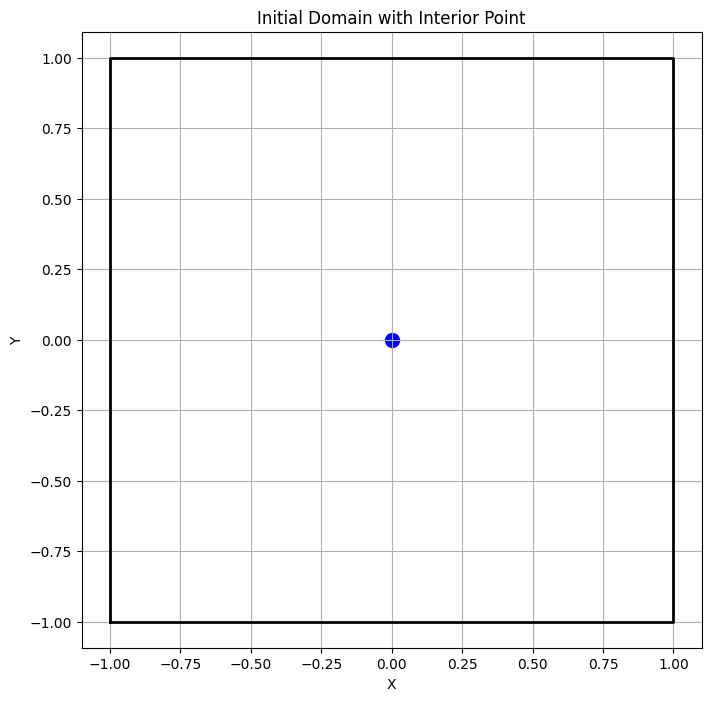

Observation space: (22,)
Step 1000: Loss=-1.7832
Step 1500: Loss=-3.9451
Step 2000: Loss=-4.2066
Step 2500: Loss=-4.5623
Step 3000: Loss=-4.8318
Step 3500: Loss=-5.2009
Step 4000: Loss=-5.4751
Step 4500: Loss=-5.8283


In [54]:
def train(env, agent, replay_buffer, 
          total_timesteps=100000, 
          batch_size=256,
          initial_random_steps=10000,
          eval_interval=5000, 
          max_ep_len=100):
    """Train the agent using SAC."""
    episode_return = 0
    episode_length = 0
    state, _ = env.reset()
    
    results = {
        'timesteps': [],
        'episode_returns': [],
        'actor_losses': [],
        'critic_losses': [],
        'alpha_values': []
    }
    
    for t in range(1, total_timesteps + 1):
        # Sample action
        if t < initial_random_steps:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)
        
        # Take step
        next_state, reward, done, truncated, info = env.step(action)
        episode_return += reward
        episode_length += 1
        
        # Store transition
        replay_buffer.add(state, action, reward, next_state, done)
        
        # Move to next state
        state = next_state
        
        # Reset if episode ends
        if done or truncated or episode_length >= max_ep_len:
            print(f"Episode Return: {episode_return:.2f} | Elements: {len(env.elements)}")
            results['timesteps'].append(t)
            results['episode_returns'].append(episode_return)
            
            state, _ = env.reset()
            episode_return = 0
            episode_length = 0
        
        # Train agent
        if replay_buffer.size() >= batch_size and t >= initial_random_steps:
            batch = replay_buffer.sample(batch_size)
            train_info = agent.train_step(batch)
            
            if t % 1000 == 0:
                results['actor_losses'].append(train_info['actor_loss'])
                results['critic_losses'].append((train_info['critic_1_loss'] + train_info['critic_2_loss'])/2)
                results['alpha_values'].append(train_info['alpha'])
                
                print(f"Timestep: {t}/{total_timesteps} | "
                      f"Actor Loss: {train_info['actor_loss']:.4f} | "
                      f"Critic Loss: {(train_info['critic_1_loss'] + train_info['critic_2_loss'])/2:.4f} | "
                      f"Alpha: {train_info['alpha']:.4f}")
        
        # Evaluate
        if t % eval_interval == 0:
            eval_return = evaluate(env, agent, num_episodes=5)
            print(f"Evaluation at timestep {t}: {eval_return:.2f}")
            
    return results

def evaluate(env, agent, num_episodes=5, render=False, max_ep_len=100):
    """Evaluate the agent."""
    returns = []
    
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_return = 0
        episode_length = 0
        done = False
        
        while not done and episode_length < max_ep_len:
            action = agent.select_action(state, evaluate=True)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_return += reward
            episode_length += 1
            
            if render:
                env.render()
                
            state = next_state
            if truncated:
                break
                
        returns.append(episode_return)
        
    return np.mean(returns)
    

def main():
    env = MeshEnvironment()
    env.plot_domain()
    
    print(f"Observation space: {env.observation_space.shape}")
    agent = SAC(state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0], hidden_dim=128)
    replay_buffer = ReplayBuffer(capacity=100_000)
    
    state, _ = env.reset()
    for t in range(1, 5000):
        action = env.action_space.sample() if t < 1000 else agent.select_action(state)
        next_state, reward, done, _, info = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        if done: state, _ = env.reset()
        
        if replay_buffer.size() >= 64 and t >= 1000 and t % 10 == 0:
            try:
                batch = replay_buffer.sample(64)
                train_info = agent.train_step(batch)
                if t % 500 == 0: print(f"Step {t}: Loss={train_info['actor_loss']:.4f}")
            except Exception as e:
                print(f"Training error at step {t}: {str(e)}")
                break


if __name__ == "__main__":
    main()
